# Exercise 4.4

## Imports

In [64]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools

## Data

In [65]:
dolphin_conn = pd.read_csv('data/dolphins.txt', sep=" ", header=None, skiprows=1)
dolphin_info = pd.read_csv('data/dolphininfo.txt', sep=" ", header=None)
display(dolphin_conn)
display(dolphin_info)

,0,1
0,11,1
1,15,1
2,16,1
3,41,1
4,43,1
...,...,...
154,58,49
155,52,51
156,56,52
157,62,54


,0,1
0,Beak,M
1,Beescratch,M
2,Bumper,M
3,CCL,F
4,Cross,M
...,...,...
57,Web,M
58,Whitetip,F
59,Zap,U
60,Zig,M


## Networkx graph

In [66]:
dolphin_list = [(index+1, {'name': row[0], 'sex': row[1]}) for index, row in dolphin_info.iterrows()]
edge_list = [(row[0], row[1]) for _, row in dolphin_conn.iterrows()]

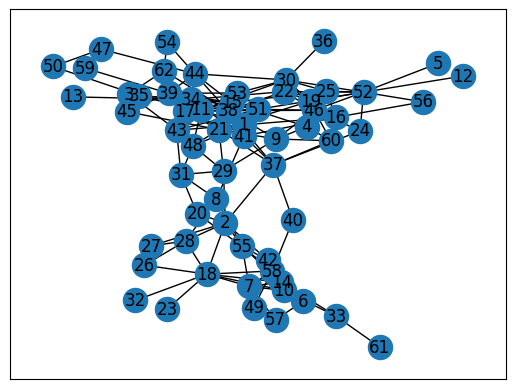

In [67]:
G = nx.Graph()
G.add_nodes_from(dolphin_list)
G.add_edges_from(edge_list)
nx.draw_networkx(G, with_labels=True)

## Algorithm

In [68]:
def dfs(dolphins, alpha, size, improved, maximal):
  alpha_cliques = []
  visited = set()
  count = 0 # Number of candidate sets traversed

  if improved:
    dolphin_list = sorted(list(dolphins), key=lambda x: dolphins.degree(x))
  else:
    dolphin_list = list(dolphins)

  for dolphin in dolphin_list:
    count += dfs_rec(dolphins, [dolphin], visited, alpha_cliques, alpha, size, improved)
  
  if maximal:
    # Inspiration from https://stackoverflow.com/questions/24075347/how-find-a-maximal-set-or-a-superset-from-a-list-of-sets-maximal-set-is-the-set
    lengths = set([len(i) for i in alpha_cliques])
    grouped = {l: [set(s) for s in alpha_cliques if l == len(s)] for l in lengths}
    max_cliques = []
    for l in lengths:
      max_cliques.extend([ list(s) for s in grouped[l] if not any([ other_s.intersection(s)==s for other_l in lengths if other_l !=l for other_s in grouped[other_l] ])])
    alpha_cliques = max_cliques
  
  return alpha_cliques, count


def dfs_rec(dolphins, dolphin_set, visited, alpha_cliques, alpha, size, improved):
  count = 1 # Update number of candidate sets traversed
  visited.add(frozenset(dolphin_set))

  # Calculate f(S)
  S = dolphins.subgraph(dolphin_set)
  min_deg = S.degree(dolphin_set[0])
  for d in dolphin_set:
    curr_deg = S.degree(d)
    if curr_deg < min_deg:
      min_deg = curr_deg

  f_S = min_deg/max(len(dolphin_set)-1, 1)

  # Check if S is an alpha-clique and add to result
  if f_S >= alpha and len(dolphin_set) > size:
    alpha_cliques.append(dolphin_set)

  # Prune based on Theorem
  stop = False
  for d in dolphin_set:
    thresh = 1 - (dolphins.degree(d)*(1-alpha))/(max(len(dolphin_set)-1, 1)*alpha)
    if f_S < thresh:
      stop = True
      break

  # If pruning condition is false move onto neighbours of current clique
  if not stop:
    if improved:
      dset = sorted(dolphin_set, key=lambda x: dolphins.degree(x))
    else:
      dset = dolphin_set
    for d in dset: # Iterate through nodes in S
      if improved:
        neighbs = sorted(dolphins.neighbors(d), key=lambda x: dolphins.degree(x))
      else:
        neighbs = dolphins.neighbors(d)
      for neighbour in neighbs:
        new_dolphin_set = [*dolphin_set, neighbour] # Set with new dolphin
        # Check that current node is not already in S and that new set is not already visited
        if neighbour not in dolphin_set and set(new_dolphin_set) not in visited:
          count += dfs_rec(dolphins, new_dolphin_set, visited, alpha_cliques, alpha, size, improved)

  return count


## Toyset testing

### Download data

In [69]:
toyset = pd.read_csv('data/toyset.txt', sep=" ", header=None, skiprows=1)
toy_edge_list = [(row[0], row[1]) for _, row in toyset.iterrows()]
display(toyset)

,0,1
0,1,2
1,1,4
2,2,3
3,2,4
4,3,4
5,3,5


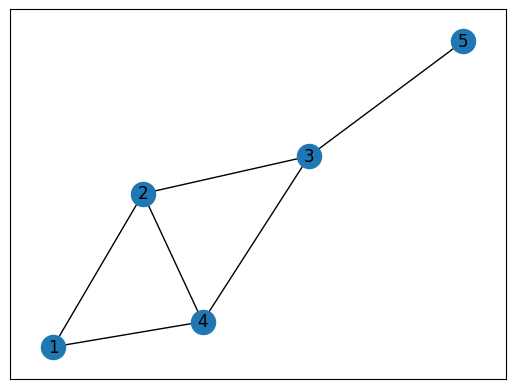

In [70]:
G_test = nx.Graph()
G_test.add_edges_from(toy_edge_list)
nx.draw_networkx(G_test, with_labels=True)

In [71]:
toy_res = dfs(G_test, 0.6, 2, False, False)
print(f"Number of toy example alpha-cliques: {len(toy_res[0])}")
print("The cliques:")
for i in toy_res[0]:
  print(i)

Number of toy example alpha-cliques: 3
The cliques:
[1, 2, 4]
[1, 2, 4, 3]
[2, 3, 4]


Result matches toysetresults.txt.

## Improved algorithm comparison

In [72]:
for i in [0.8, 0.7, 0.6, 0.5]:
  print(f"\nAlpha={i}")
  res_basic = dfs(G, i, 2, False, False)
  res_improved = dfs(G, i, 2, True, False)
  print(f"Number of tested candidates with basic algorithm: {res_basic[1]}")
  print(f"Number of tested candidates with improved algorithm: {res_improved[1]}")


Alpha=0.8
Number of tested candidates with basic algorithm: 6977
Number of tested candidates with improved algorithm: 6977

Alpha=0.7
Number of tested candidates with basic algorithm: 45010
Number of tested candidates with improved algorithm: 45010

Alpha=0.6
Number of tested candidates with basic algorithm: 369845
Number of tested candidates with improved algorithm: 369845

Alpha=0.5
Number of tested candidates with basic algorithm: 3346675
Number of tested candidates with improved algorithm: 3346675


## Maximal alpha cliques

In [73]:
max_alpha_res = dfs(G, 0.8, 4, True, True)
print(f"Number of maximal alpha-cliques found: {len(max_alpha_res[0])}")
print("The cliques:")
for i in max_alpha_res[0]:
  print(i)

print("\nGender distribution:")
for i in max_alpha_res[0]:
  print([G.nodes[j]['sex'] for j in i])

print("\nNames:")
for i in max_alpha_res[0]:
  print([G.nodes[j]['name'] for j in i])

Number of maximal alpha-cliques found: 4
The cliques:
[7, 10, 14, 18, 58]
[7, 42, 10, 14, 55, 58]
[34, 38, 39, 44, 15, 17]
[46, 19, 52, 22, 25, 30]

Gender distribution:
['M', 'M', 'M', 'M', 'M']
['M', 'M', 'M', 'M', 'M', 'M']
['F', 'F', 'F', 'F', 'F', 'F']
['M', 'M', 'F', 'M', 'M', 'M']

Names:
['DN21', 'Feather', 'Gallatin', 'Jet', 'Web']
['DN21', 'SN90', 'Feather', 'Gallatin', 'Upbang', 'Web']
['Scabs', 'SN4', 'SN63', 'Stripes', 'Grin', 'Hook']
['Topless', 'Jonah', 'Trigger', 'MN105', 'MN83', 'Patchback']
